Para que funcione, se debe descargar el conjunto de datos desde el siguiente link
https://drive.google.com/drive/folders/1n5D-D4Hd96d9foA17KO1LQCH6ds7UHcX?usp=sharing

Luego, crear una carpeta en la raiz de la unidad de drive, con el nombre de data_ia y alli colocar la carpeta data.

Enjoy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install gdown

url = 'https://drive.google.com/uc?id=1yBoQkSuNUQg0b2jtqSug3Z6QVVwID-wC'


In [ ]:
import gdown
gdown.download(url,output="data", quiet=False)

Permission denied: https://drive.google.com/uc?id=1yBoQkSuNUQg0b2jtqSug3Z6QVVwID-wC
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
## Para que funcione se debe activar drive a mano
path = '/content/drive/MyDrive/data_ia/data/'
!wget https://raw.githubusercontent.com/inteligenciafrvm/inteligenciafrvm/master/Clases%20pr%C3%A1cticas/funciones_utiles.py

--2021-06-11 00:21:56--  https://raw.githubusercontent.com/inteligenciafrvm/inteligenciafrvm/master/Clases%20pr%C3%A1cticas/funciones_utiles.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4786 (4.7K) [text/plain]
Saving to: ‘funciones_utiles.py.2’

funciones_utiles.py 100%[===================>]   4.67K  --.-KB/s    in 0s      

2021-06-11 00:21:57 (49.2 MB/s) - ‘funciones_utiles.py.2’ saved [4786/4786]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision

from torchvision import models
from tqdm import tqdm_notebook as progressbar
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from funciones_utiles import imshow_tensor
import torch
from torch import nn
from torchvision import models
from tqdm import tqdm_notebook as progressbar
from sklearn.ensemble import RandomForestClassifier
import torch.optim as optim
from skimage import io
from funciones_utiles import imshow
from torchvision.datasets.utils import download_and_extract_archive
import cv2
from PIL import Image
from scipy import misc

ModuleNotFoundError: ignored

In [ ]:

batch_size = 4
num_workers = 2
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


torch.Size([4, 3, 224, 224])
tensor([4, 3, 2, 0])
['mindy_kaling', 'madonna', 'jerry_seinfeld', 'ben_afflek']


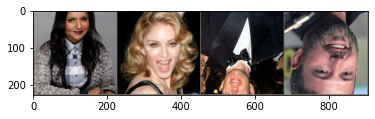

In [ ]:
# dataset
data = ImageFolder(os.path.join(path, 'train'), transform)

# data loader
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

image_batch, labels = next(iter(loader))
print(image_batch.size())
print(labels)
print([data.classes[lbl] for lbl in labels])
grid = make_grid(image_batch)
imshow_tensor(grid)

In [ ]:


class FeatureExtractor(nn.Module):
    def __init__(self):        
        super().__init__()
        # leer red pre-entrenada
        model = models.resnet18(pretrained=True)
        
        # congelamos los parámetros
        for p in model.parameters():
            p.requires_grad_(False)
            
        # armamos modelo secuencial que incluya todas las capas salvo la última (fc)
        layers = list(model.children())[:-1] # quitamos la última capa
        self.net = nn.Sequential(*layers) 
        
    def forward(self, x):        
        N = x.size(0)  # batch size
        x = self.net(x)
        return x.view(N, -1) # redimensionamos la salida para adaptarla a nuestro modelo

In [ ]:
def features_and_labels(set_):
    if set_ not in ('train', 'val'):
        raise ValueError('not a valid data set')
        
    transform = transforms.Compose([    
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    data = ImageFolder(os.path.join(path, set_), transform)
    
    loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
    
    extractor = FeatureExtractor()
    extractor.eval()
    
    features, labels = [], []
    
    for img, lbl in progressbar(loader):
        feat = extractor(img)  
        features.append(feat)
        labels.append(lbl)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels

In [ ]:
train_features, train_labels = features_and_labels('train')
val_features, val_labels = features_and_labels('val')
print(train_features.size(), val_features.size())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



torch.Size([93, 512]) torch.Size([25, 512])


In [ ]:
x_train, y_train = train_features.cpu().numpy(), train_labels.cpu().numpy().reshape(-1, 1)
x_test, y_test = val_features.cpu().numpy(), val_labels.cpu().numpy().reshape(-1, 1)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(93, 512) (93, 1)
(25, 512) (25, 1)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        # interfaz de nn.Conv2d:
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0) 
        self.conv1 = nn.Conv2d(3, 6, 5)
        # nn.MaxPool2d(kernel_size, stride=None, padding=0)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 16 canales de salida * 5 alto de la imagen * 5 ancho de la imagen
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
classif_RF = RandomForestClassifier(max_depth=2, random_state=0)
classif_RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print("El porcentaje de aciertos para Random Forest es: " + str(round(classif_RF.score(x_test,y_test),6)*100) + "%")

El porcentaje de aciertos para Random Forest es: 60.0%


In [ ]:
x_train.shape

(93, 512)

In [ ]:
y_pred = classif_RF.predict(x_test)
y_pred

array([4, 2, 2, 4, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 3, 4,
       4, 4, 4])

Carga de imagen de prueba


In [ ]:

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data = ImageFolder(os.path.join(path, 'val_3'), transform)
print(data)

Dataset ImageFolder
    Number of datapoints: 1
    Root location: /content/drive/MyDrive/data_ia/data/val_3
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
loader

In [ ]:
image_batch, labels = next(iter(loader))
image_batch

tensor([[[[-0.7993, -0.7993, -1.0048,  ..., -0.6623, -0.6109, -0.5938],
          [-0.7822, -0.7993, -1.0048,  ..., -0.6452, -0.5938, -0.6109],
          [-0.7822, -0.8164, -1.0048,  ..., -0.6794, -0.6109, -0.5938],
          ...,
          [-0.8678, -0.8335, -0.8335,  ...,  1.1529,  0.4166, -0.9705],
          [-0.7993, -0.8335, -0.8678,  ...,  1.1358,  0.5193, -0.9363],
          [-0.8335, -0.8507, -0.8678,  ...,  1.1700,  0.5878, -0.9020]],

         [[-0.7402, -0.7402, -0.8978,  ..., -0.7052, -0.6527, -0.6176],
          [-0.7227, -0.7577, -0.9153,  ..., -0.6877, -0.6527, -0.6176],
          [-0.7227, -0.7752, -0.8978,  ..., -0.7227, -0.6527, -0.5826],
          ...,
          [-0.7402, -0.6527, -0.6527,  ...,  0.9580,  0.3102, -0.8978],
          [-0.6527, -0.6352, -0.6527,  ...,  0.9580,  0.3803, -0.8803],
          [-0.6352, -0.6176, -0.6176,  ...,  0.9930,  0.4503, -0.8452]],

         [[-0.7064, -0.7064, -0.8110,  ..., -0.6541, -0.6193, -0.5844],
          [-0.6890, -0.6890, -

torch.Size([1, 3, 224, 224])
tensor([0])
['clasif']


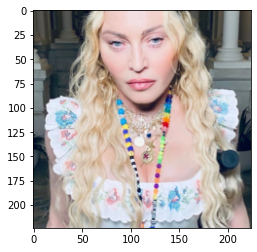

In [ ]:
print(image_batch.size())
print(labels)
print([data.classes[lbl] for lbl in labels])
grid = make_grid(image_batch)
imshow_tensor(grid)

In [ ]:
extractor = FeatureExtractor()
extractor.eval()

features, labels = [], []

for img, lbl in progressbar(loader):
    feat = extractor(img)  
    features.append(feat)
    labels.append(lbl)

features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
x = features.cpu().numpy()
x

array([[6.07144356e-01, 2.15924668e+00, 2.24823380e+00, 3.54433537e-01,
        5.09636223e-01, 2.76658207e-01, 2.27954358e-01, 9.06305015e-01,
        5.12607694e-01, 1.87655926e+00, 5.53850606e-02, 1.70594871e-01,
        4.49028105e-01, 3.25240761e-01, 9.09129679e-01, 9.22165692e-01,
        1.47640026e+00, 3.38301854e-03, 9.07900453e-01, 6.02458775e-01,
        2.93329388e-01, 1.02113652e+00, 1.52543890e+00, 5.34217119e-01,
        1.45795631e+00, 2.08922595e-01, 8.54721665e-01, 1.75015354e+00,
        2.97947526e+00, 1.20124303e-01, 1.04793489e+00, 1.25251555e+00,
        6.01989448e-01, 3.88210654e-01, 2.87291229e-01, 1.27253115e+00,
        1.39945638e+00, 7.89279878e-01, 2.11592698e+00, 1.16006994e+00,
        4.52295929e-01, 1.77759790e+00, 1.97287345e+00, 5.64104378e-01,
        2.55110836e+00, 6.58984959e-01, 1.08539648e-01, 1.03079736e+00,
        1.98046482e+00, 1.81199050e+00, 2.83738226e-01, 8.92348707e-01,
        1.50800872e+00, 8.04223418e-02, 9.65454102e-01, 4.732992

In [ ]:
pred = classif_RF.predict(x)
pred

array([3])

In [ ]:
data ={0 :"Ben",1 :"Elton",2 :"Jerry",3 :"Maddona",4 :"Mindy"}

print(data[pred[0]])

Maddona


El clasificador a pesar de tener poco dataset de imagenes (armado a mano), se puede ver que reconoce bastante bien a los famosos.
 